In [2]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from ipywidgets import widgets
from IPython.display import display, clear_output

In [3]:
%run functions_models_12.ipynb

## Create two classes, Model and State.  

### The class Model will store instances of different constitutive models.  The class State will store instances of different state variables such as stress, strain, or internal variables.


In [4]:
class Model:
    def __init__(self,**kwargs):
        for attr in kwargs.keys():
            self.__dict__[attr] = kwargs[attr]

class State:
    def __init__(self,**kwargs):
        for attr in kwargs.keys():
            self.__dict__[attr] = kwargs[attr]    


In [5]:
# Example of State:

Initial_state = State(
    stress   = np.array([200,200,200,0,0,0]),   # stress, kPa
    strain   = np.array([0,0,0,0,0,0]),         # strain
    strainp  = np.array([0,0,0,0,0,0]),         # plastic strain
                                                
                                                # create internal variables here 
)  


# Example of Model:

DP_1 = Model(name = 'DP',
           K    = 50e3,             # elastic bulk modulus, kPa
           G    = 25e3,             # elastic shear modulus, kPa
           phi  = 37/180*np.pi,     # frictional angle, rad
           c    = 0,                # cohension, kPa
           psi  = 37/180*np.pi      # if equal to Model.phi, associate flow rule
          )                         # otherwise, non-associate, rad


MC_1 = Model(name = 'MC',             
           K    = 50e3,             # elastic bulk modulus, kPa             
           G    = 25e3,             # elastic shear modulus, kPa             
           phi  = 37/180*np.pi,     # frictional angle, rad             
           c    = 0,                # cohension, kPa             
           psi  = 10/180*np.pi      # if equal to Model.phi, associate flow rule           
          )                         # otherwise, non-associate, rad

VM_1 = Model (name = 'VM',
             # create all model parameters required here
             
             
             )


## Define yield surface and compute f with given stress and state parameters

In [6]:
def yieldSurface(sigm, Model, State):
    J1, J2D, theta = invariant(sigm)
    p = J1 / 3
    s = sigm - p * I
    
    if Model.name == 'DP':
    
        alpha = 2 * np.sin(Model.phi) / (np.sqrt(3) * (3-np.sin(Model.phi)))
        k = 6 * Model.c * np.cos(Model.phi) / (np.sqrt(3) * (3-np.sin(Model.phi)))
        f_pred = np.real(np.emath.sqrt(J2D)) - alpha * J1 - k
        
    if Model.name == 'MC':
        
        f_pred = -1/3*J1*np.sin(Model.phi)+np.sqrt(J2D)*(np.cos(theta)+1/np.sqrt(3)*np.sin(theta)*np.sin(Model.phi))-Model.c*np.cos(Model.phi)
    
   # if Model.name == 'VM':
        
        # f_pred = ?
        
    return f_pred
           


## Define a function to compute $\frac{\partial f}{\partial \sigma}$

In [7]:
def fnormal(sigm, Model, State):
    J1, J2D, theta = invariant(sigm)
  
    p = J1 / 3
    s = sigm - p * I

    a1 = I
    a2 = 1/(2*np.sqrt(J2D))*s;
    a2[3:6] = a2[3:6] * 2;
    a3 = np.array([s[1]*s[2]-s[5]**2+J2D/3,
                   s[0]*s[2]-s[4]**2+J2D/3,
                   s[0]*s[1]-s[3]**2+J2D/3,
                   2*(s[4]*s[5]-s[2]*s[3]),
                   2*(s[3]*s[5]-s[1]*s[4]),
                   2*(s[3]*s[4]-s[1]*s[5])])

    if Model.name == 'DP':
        alpha = 2*np.sin(Model.phi)/(np.sqrt(3)*(3-np.sin(Model.phi)))
        k = 6*Model.c*np.cos(Model.phi)/(np.sqrt(3)*(3-np.sin(Model.phi)));
        dfds = a2-alpha*a1;

    if Model.name == 'MC':
        C1 = -1/3*np.sin(Model.phi)
        if np.abs(theta+np.pi/6) < 1e-6:
            C2 = 1/2*(np.sqrt(3)-np.sin(Model.phi)/np.sqrt(3))
            C3 = 0
        elif np.abs(theta-np.pi/6) < 1e-6:
            C2 = 1/2*(np.sqrt(3)+np.sin(Model.phi)/np.sqrt(3))
            C3 = 0
        else:
            C2 = np.cos(theta)*(1+np.tan(theta)*np.tan(3*theta)+np.sin(Model.phi)*(-np.tan(3*theta)+np.tan(theta))/np.sqrt(3))
            C3 = (np.sqrt(3)*np.sin(theta)-np.cos(theta)*np.sin(Model.phi))/(2*J2D*np.cos(3*theta))

        dfds = C1*a1+C2*a2+C3*a3
        
   # if Model.name == 'VM':
       
        # dfds = ?

    
    return dfds
            
            
    
    
        
        
    

## Define a function to compute $\frac{\partial g}{\partial \sigma}$

In [8]:
def gnormal(sigm, Model, State):
    J1, J2D, theta = invariant(sigm)
    

    p = J1 / 3
    s = sigm - p * I

    a1 = I
    a2 = 1/(2*np.sqrt(J2D))*s;
    a2[3:6] = a2[3:6] * 2;
    a3 = np.array([s[1]*s[2]-s[5]**2+J2D/3,
                   s[0]*s[2]-s[4]**2+J2D/3,
                   s[0]*s[1]-s[3]**2+J2D/3,
                   2*(s[4]*s[5]-s[2]*s[3]),
                   2*(s[3]*s[5]-s[1]*s[4]),
                   2*(s[3]*s[4]-s[1]*s[5])])

    if Model.name == 'DP':
        alpha_phi = 2*np.sin(Model.psi)/(np.sqrt(3)*(3-np.sin(Model.psi)))
        dgds = a2-alpha_phi*a1;

    if Model.name == 'MC':
        C1 = -1/3*np.sin(Model.psi)
        if np.abs(theta+np.pi/6) < 1e-6:
            C2 = 1/2*(np.sqrt(3)-np.sin(Model.psi)/np.sqrt(3))
            C3 = 0
        elif np.abs(theta-np.pi/6) < 1e-6:
            C2 = 1/2*(np.sqrt(3)+np.sin(Model.psi)/np.sqrt(3))
            C3 = 0
        else:
            C2 = np.cos(theta)*(1+np.tan(theta)*np.tan(3*theta)+np.sin(Model.psi)*(-np.tan(3*theta)+np.tan(theta))/np.sqrt(3))
            C3 = (np.sqrt(3)*np.sin(theta)-np.cos(theta)*np.sin(Model.psi))/(2*J2D*np.cos(3*theta))

        dgds = C1*a1+C2*a2+C3*a3
        
   # if Model.name == 'VM':
       
        # dgds = ?
            
    return dgds
            
  

## Define a function to compute $K_p$

In [9]:
def plasticModulus(sigm, Model, State):
    p = (sigm[0]+sigm[1]+sigm[2]) / 3
    s = sigm - p * I
    
    if Model.name == 'DP' or 'MC':
        Kp = 0
    
   # if Model.name == 'VM':
        # Kp = ?
            
        
    return Kp


## Update stress and strain explicitly using ${\sigma} = {\sigma} + {\dot \sigma}$ and ${\epsilon} = {\epsilon} + {\dot \epsilon}$

In [10]:
def constitutiveDriver(Model, incr, State, Load_tag):
    inc_frac = 1
    Cel = C_el(Model,State)
    deps_trial, dsigm_trial = Bardet(Cel, incr, Load_tag, inc_frac)
    
    sigm_t = State.stress + dsigm_trial
    f_pred = yieldSurface(sigm_t, Model, State)
    
    
    if f_pred <=0:     # elastic loading
        State.stress = sigm_t
        State.strain = State.strain + deps_trial
        
    else:
        if yieldSurface(State.stress, Model, State) > 0:
            beta = 0
        else:          # solve for the point where the path crosses the yield surface
            find_crosspoint = lambda x: yieldSurface(State.stress + x * dsigm_trial, Model, State)
            beta = root_scalar(find_crosspoint,bracket = [0,1]).root
            
        # update stress and strain to the point on yield surface
        State.stress = State.stress + beta * dsigm_trial
        State.strain = State.strain + beta * deps_trial
        
        # compute dfds, dgds and Kp
        dfds = fnormal(State.stress, Model, State)
        dgds = gnormal(State.stress, Model, State)
        Kp = plasticModulus(State.stress, Model, State)
        
        # form the elastoplastic tangent moduli
        temp1 = colonProduct_T4_T2(C_el(Model, State), dgds)
        temp2 = colonProduct_T4_T2(C_el(Model, State), dfds)
        num_Cepl = dyadicProduct(temp1, temp2)
        denom_L = Kp + colonProduct(dfds, temp1)
        Cepl = C_el(Model, State) - num_Cepl / denom_L
        
        # compute deps and dsigm
        inc_frac = 1 - beta
        deps, dsigm = Bardet(Cepl, incr, Load_tag, inc_frac)
        
        # compute loading index
        temp3 = colonProduct_T4_T2(Cel, deps)
        L = colonProduct(dfds, temp3) / denom_L
        
        if L > 0:
            deps_p = L * dgds
            
            # update internal variable 
            
            
        else: 
            deps_p = 0
        
        # update stress and strain 
        State.stress = State.stress + dsigm
        State.strain = State.strain +  deps
        State.strainp = State.strainp + deps_p
        
    return State
        

## Input the initial state, model parameters and testing configuration and plot the result

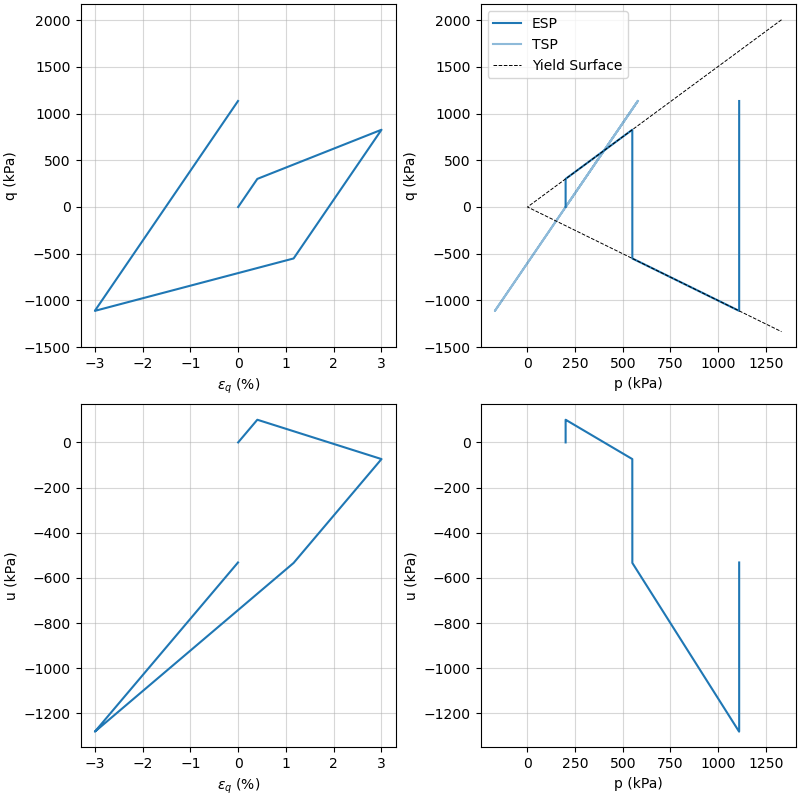

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), constrained_layout=True) # create a new figure and a set of subplots


Initial_state = State(
    stress   = np.array([200,200,200,0,0,0]),   # stress, kPa
    strain   = np.array([0,0,0,0,0,0]),         # strain
    strainp  = np.array([0,0,0,0,0,0]),         # plastic strain
    k        = 1.2,                             # initial size of yield surface, kPa (for VM)
                                                # initial 'size' (slope) of yield surface (for DP_hardening)
    alpha    = np.array([0, 0, 0, 0, 0, 0]),    # initial back-stress, kPa (for VM)
                                                # initial back-stress ratio (for DP_hardening)
    p0       = np.array([200]),                 # initial p0 value (for MCC)
    e        = np.array([1.75])                 # initial void ratio (for MCC)
)    



MC_1 = Model(name = 'MC',             
           K    = 50e3,             # elastic bulk modulus, kPa             
           G    = 25e3,             # elastic shear modulus, kPa             
           phi  = 37/180*np.pi,     # frictional angle, rad             
           c    = 0,                # cohension, kPa             
           psi  = 10/180*np.pi      # if equal to Model.phi, associate flow rule           
          )                         # otherwise, non-associate, rad

result = runningModule(State = Initial_state, 
                       Model = MC_1,                      # specify which model to simulate
                       Load_tag = 100,                     # 100: undrained, 110: drained
                       Load_limit = 0.03,                   # eps_a limit
                       Load_cyclic = 1,                    # 0: monotonic, 1: cyclic
                       Load_num_cyc = 1,                   # number of cycles
                       ax = ax                             # specify to plot on which figure
                    )


In [12]:
# Plot in the previous figure


Initial_state = State(
    stress   = np.array([200,200,200,0,0,0]),   # stress, kPa
    strain   = np.array([0,0,0,0,0,0]),         # strain
    strainp  = np.array([0,0,0,0,0,0]),         # plastic strain
    k        = 1.2,                             # initial size of yield surface, kPa (for VM)
                                                # initial 'size' (slope) of yield surface (for DP_hardening)
    alpha    = np.array([0, 0, 0, 0, 0, 0]),    # initial back-stress, kPa (for VM)
                                                # initial back-stress ratio (for DP_hardening)
    p0       = np.array([200]),                 # initial p0 value (for MCC)
    e        = np.array([1.75])                 # initial void ratio (for MCC)
)    



MC_2 = Model(name = 'MC',             
           K    = 50e3,             # elastic bulk modulus, kPa             
           G    = 25e3,             # elastic shear modulus, kPa             
           phi  = 37/180*np.pi,     # frictional angle, rad             
           c    = 0,                # cohension, kPa             
           psi  = 20/180*np.pi      # if equal to Model.phi, associate flow rule           
          )                         # otherwise, non-associate, rad

result = runningModule(State = Initial_state, 
                       Model = MC_2,                      # specify which model to simulate
                       Load_tag = 100,                     # 100: undrained, 110: drained
                       Load_limit = 0.03,                   # eps_a limit
                       Load_cyclic = 1,                    # 0: monotonic, 1: cyclic
                       Load_num_cyc = 1,                   # number of cycles
                       ax = ax                             # specify to plot on which figure
                    )


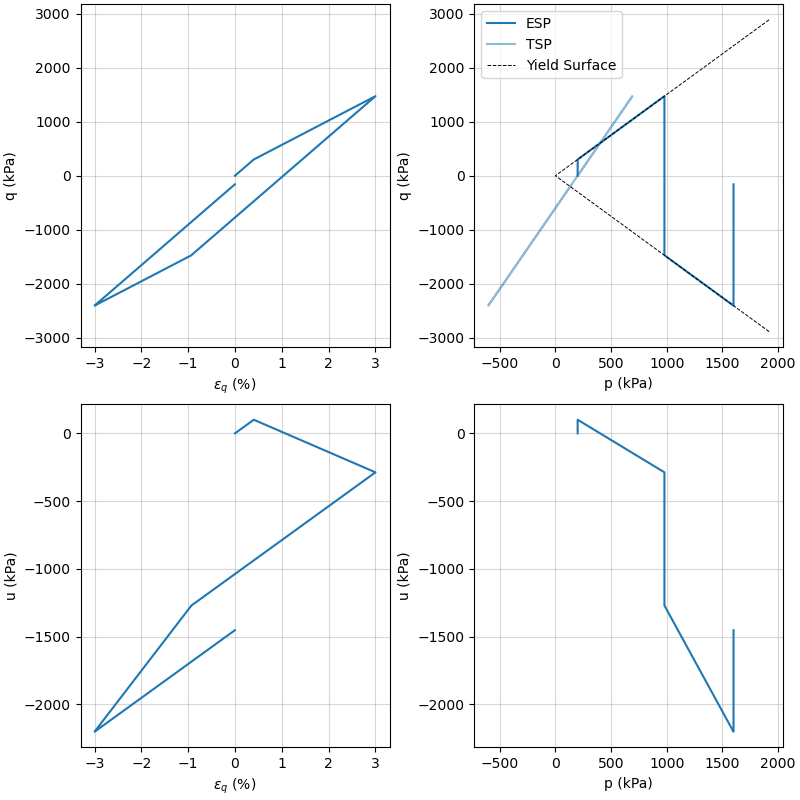

In [13]:
fig, ax2 = plt.subplots(2, 2, figsize=(8, 8), constrained_layout=True) # create a new figure and a set of subplots


Initial_state = State(
    stress   = np.array([200,200,200,0,0,0]),   # stress, kPa
    strain   = np.array([0,0,0,0,0,0]),         # strain
    strainp  = np.array([0,0,0,0,0,0]),         # plastic strain
    k        = 1.2,                             # initial size of yield surface, kPa (for VM)
                                                # initial 'size' (slope) of yield surface (for DP_hardening)
    alpha    = np.array([0, 0, 0, 0, 0, 0]),    # initial back-stress, kPa (for VM)
                                                # initial back-stress ratio (for DP_hardening)
    p0       = np.array([200]),                 # initial p0 value (for MCC)
    e        = np.array([1.75])                 # initial void ratio (for MCC)
)    



DP_1 = Model(name = 'DP',
           K    = 50e3,             # elastic bulk modulus, kPa
           G    = 25e3,             # elastic shear modulus, kPa
           phi  = 37/180*np.pi,     # frictional angle, rad
           c    = 0,                # cohension, kPa
           psi  = 37/180*np.pi      # if equal to Model.phi, associate flow rule
          )                         # otherwise, non-associate, rad

result = runningModule(State = Initial_state, 
                       Model = DP_1,                      # specify which model to simulate
                       Load_tag = 100,                     # 100: undrained, 110: drained
                       Load_limit = 0.03,                   # eps_a limit
                       Load_cyclic = 1,                    # 0: monotonic, 1: cyclic
                       Load_num_cyc = 1,                   # number of cycles
                       ax = ax2                             # specify to plot on which figure
                    )


In [14]:
# Plot in the previous figure


Initial_state = State(
    stress   = np.array([200,200,200,0,0,0]),   # stress, kPa
    strain   = np.array([0,0,0,0,0,0]),         # strain
    strainp  = np.array([0,0,0,0,0,0]),         # plastic strain
    k        = 1.2,                             # initial size of yield surface, kPa (for VM)
                                                # initial 'size' (slope) of yield surface (for DP_hardening)
    alpha    = np.array([0, 0, 0, 0, 0, 0]),    # initial back-stress, kPa (for VM)
                                                # initial back-stress ratio (for DP_hardening)
    p0       = np.array([200]),                 # initial p0 value (for MCC)
    e        = np.array([1.75])                 # initial void ratio (for MCC)
)    



DP_2 = Model(name = 'DP',
           K    = 50e3,             # elastic bulk modulus, kPa
           G    = 25e3,             # elastic shear modulus, kPa
           phi  = 37/180*np.pi,     # frictional angle, rad
           c    = 0,                # cohension, kPa
           psi  = 20/180*np.pi      # if equal to Model.phi, associate flow rule
          )                         # otherwise, non-associate, rad

result = runningModule(State = Initial_state, 
                       Model = DP_2,                      # specify which model to simulate
                       Load_tag = 100,                     # 100: undrained, 110: drained
                       Load_limit = 0.03,                   # eps_a limit
                       Load_cyclic = 1,                    # 0: monotonic, 1: cyclic
                       Load_num_cyc = 1,                   # number of cycles
                       ax = ax2                             # specify to plot on which figure
                    )
